In [1]:
from google.colab import auth
auth.authenticate_user()

# Installig useful libraries

In [2]:
#Install spacy
!pip install spacy

In [3]:
%%capture

!pip install pycld2
!pip install contractions

In [4]:
!pip install pyLDAvis
#!pip install -U gensim
!pip install gensim==3.8.3.

# Importing Libraries

In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import time
import contractions
from pycld2 import detect
import nltk;
from nltk.corpus import stopwords
import scipy.stats as stats
import matplotlib.pyplot as plotter
from google.colab import files
from google.colab import drive
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Text Preprocessing and Text Representation for Topic Modeling

In [6]:
#mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
AmazonReviews = pd.read_csv('/content/drive/MyDrive/Text_Mining_Project_Amazon/AmazonFinal_general.csv')
AmazonReviews.head()

,Text,Summary,Score
0,bought several vitality canned dog food produc...,Good Quality Dog Food,5
1,product arrived labeled jumbo salted peanutsth...,Not as Advertised,1
2,confection around centuries light pillowy citr...,"""Delight"" says it all",4
3,looking secret ingredient robitussin believe f...,Cough Medicine,2
4,great taffy great price wide assortment yummy ...,Great taffy,5


In [8]:
print(AmazonReviews.shape)

(393735, 3)


In [9]:
# Convert to list
data = AmazonReviews.Text.values.tolist()
pprint(data[:1])

['bought several vitality canned dog food products found good quality product '
 'looks like stew processed meat smells better labrador finicky appreciates '
 'product better']


In [10]:
#Tokenization 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
data_words = list(sent_to_words(data))

print(data_words[:1])

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

In [ ]:
# NLTK Stop words
nltk.download('stopwords')
stop_words = stopwords.words('english')

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Bigrams representation

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['buy', 'several', 'vitality', 'can', 'dog', 'food', 'product', 'find', 'good', 'quality', 'product', 'look', 'stew', 'process', 'meat', 'smell', 'well', 'labrador', 'appreciate', 'product', 'better']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


In [ ]:
id2word[0]

'appreciate'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('appreciate', 1),
  ('better', 1),
  ('buy', 1),
  ('can', 1),
  ('dog', 1),
  ('find', 1),
  ('food', 1),
  ('good', 1),
  ('labrador', 1),
  ('look', 1),
  ('meat', 1),
  ('process', 1),
  ('product', 3),
  ('quality', 1),
  ('several', 1),
  ('smell', 1),
  ('stew', 1),
  ('vitality', 1),
  ('well', 1)]]

### Tf-Idf Representation

In [11]:
# Remove Emails
data_tfidf = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data_tfidf = [re.sub('\s+', ' ', sent) for sent in data_tfidf]

# Remove distracting single quotes
data_tfidf = [re.sub("\'", "", sent) for sent in data_tfidf]

data_tfidf = list(sent_to_words(data_tfidf))

pprint(data_tfidf[:1])

[['bought',
  'several',
  'vitality',
  'canned',
  'dog',
  'food',
  'products',
  'found',
  'good',
  'quality',
  'product',
  'looks',
  'like',
  'stew',
  'processed',
  'meat',
  'smells',
  'better',
  'labrador',
  'finicky',
  'appreciates',
  'product',
  'better']]


In [12]:
#data_words_tf = list(sent_to_words(data_tfidf))

#print(data_words_tf[:1])

In [13]:
def lemmatization_tf(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized_tf = lemmatization_tf(data_tfidf, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_tf[:2])

['buy several vitality can dog food product find good quality product look stew process meat smell well labrador appreciate product better', 'product arrive label jumbo salt peanutsthe peanut actually small sized unsalted sure error vendor intend represent product jumbo']


In [14]:
vectorizer_tfidf = TfidfVectorizer()  

In [15]:
vectors = vectorizer_tfidf.fit(data_lemmatized_tf)

In [16]:
data_tfidf = vectorizer_tfidf.transform(data_lemmatized_tf)  #fit_transform_tfidf

In [17]:
print(data_tfidf[0], '\n', data_tfidf[0])

  (0, 129580)	0.13072537055136138
  (0, 127633)	0.3979440461756776
  (0, 110624)	0.30887592925351515
  (0, 106001)	0.18491669371029132
  (0, 102706)	0.19260502192486506
  (0, 92370)	0.17506445697153927
  (0, 90333)	0.32793276059012944
  (0, 90233)	0.23529304441585788
  (0, 68550)	0.2217015002635409
  (0, 65582)	0.14909333949449144
  (0, 62422)	0.40717589676937493
  (0, 49235)	0.09331994068378954
  (0, 44268)	0.14120183516602752
  (0, 42143)	0.11660357997569576
  (0, 33292)	0.17094054061728928
  (0, 15795)	0.20632926945477512
  (0, 14824)	0.11247608498940885
  (0, 9788)	0.17969424983064355
  (0, 4930)	0.26106902555472866 
   (0, 129580)	0.13072537055136138
  (0, 127633)	0.3979440461756776
  (0, 110624)	0.30887592925351515
  (0, 106001)	0.18491669371029132
  (0, 102706)	0.19260502192486506
  (0, 92370)	0.17506445697153927
  (0, 90333)	0.32793276059012944
  (0, 90233)	0.23529304441585788
  (0, 68550)	0.2217015002635409
  (0, 65582)	0.14909333949449144
  (0, 62422)	0.40717589676937493
  (0

In [18]:
data_tfidf.shape

(393735, 133622)

In [19]:
voc = vectorizer_tfidf.vocabulary_
voc

{'buy': 14824,
 'several': 102706,
 'vitality': 127633,
 'can': 15795,
 'dog': 33292,
 'food': 44268,
 'product': 90333,
 'find': 42143,
 'good': 49235,
 'quality': 92370,
 'look': 65582,
 'stew': 110624,
 'process': 90233,
 'meat': 68550,
 'smell': 106001,
 'well': 129580,
 'labrador': 62422,
 'appreciate': 4930,
 'better': 9788,
 'arrive': 5474,
 'label': 62335,
 'jumbo': 61138,
 'salt': 99254,
 'peanutsthe': 83996,
 'peanut': 83949,
 'actually': 751,
 'small': 105832,
 'sized': 105032,
 'unsalted': 125062,
 'sure': 113846,
 'error': 37961,
 'vendor': 126889,
 'intend': 58918,
 'represent': 95988,
 'confection': 23881,
 'century': 17962,
 'light': 64205,
 'pillowy': 85944,
 'case': 17171,
 'filbert': 41955,
 'cut': 28005,
 'tiny': 119771,
 'square': 109440,
 'liberally': 63946,
 'coat': 21759,
 'powdered': 88525,
 'sugar': 112740,
 'chewy': 19339,
 'highly': 54356,
 'recommend': 94400,
 'yummy': 133318,
 'treat': 121537,
 'familiar': 40444,
 'story': 111421,
 'seduce': 101522,
 'sell

# Topic Modeling

## Gensim Model

### Bow model

In [ ]:
def compute_coherence_lda(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5000,
                                           passes=10,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('\nCoherence Score: ', coherence_lda)
        coherence_values.append(coherence_lda)

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list0, coherence_values0 = compute_coherence_lda(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=4)


Coherence Score:  0.3990478265216856

Coherence Score:  0.5263269132164244

Coherence Score:  0.6021366495357606

Coherence Score:  0.5947519807227098

Coherence Score:  0.5680406085278673

Coherence Score:  0.5917348194461003

Coherence Score:  0.5850483399928259


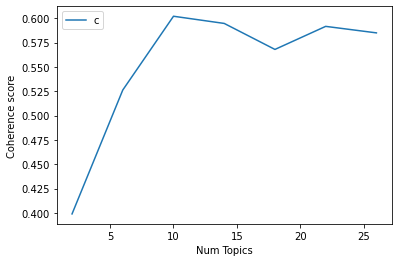

In [ ]:
# Show graph
limit=30; start=2; step=4;
x0 = range(start, limit, step)
plt.plot(x0, coherence_values0)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5000,
                                           passes=10,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [ ]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('coffee', 0.22987172),
   ('bean', 0.044289544),
   ('cup', 0.02738514),
   ('strong', 0.019824151),
   ('blend', 0.019151924),
   ('roast', 0.017400078),
   ('vanilla', 0.016170593),
   ('dark', 0.015397544),
   ('flavor', 0.015159163),
   ('brew', 0.0149488095)]),
 (1,
  [('sauce', 0.054147914),
   ('hot', 0.039541274),
   ('add', 0.02615016),
   ('soup', 0.025119955),
   ('salt', 0.023493508),
   ('cook', 0.023167165),
   ('pasta', 0.018859403),
   ('chicken', 0.018550407),
   ('spice', 0.016813682),
   ('rice', 0.01641409)]),
 (2,
  [('food', 0.13886246),
   ('dog', 0.080552235),
   ('cat', 0.046165843),
   ('treat', 0.034586884),
   ('eat', 0.027356533),
   ('baby', 0.01973451),
   ('formula', 0.01830149),
   ('feed', 0.017827474),
   ('ingredient', 0.010850454),
   ('give', 0.010835789)]),
 (3,
  [('taste', 0.04821791),
   ('flavor', 0.034787294),
   ('would', 0.023871033),
   ('try', 0.0145971645),
   ('think', 0.012830491),
   ('really', 0.012356067),
   ('sugar', 0.01

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.230*"coffee" + 0.044*"bean" + 0.027*"cup" + 0.020*"strong" + '
  '0.019*"blend" + 0.017*"roast" + 0.016*"vanilla" + 0.015*"dark" + '
  '0.015*"flavor" + 0.015*"brew"'),
 (1,
  '0.054*"sauce" + 0.040*"hot" + 0.026*"add" + 0.025*"soup" + 0.023*"salt" + '
  '0.023*"cook" + 0.019*"pasta" + 0.019*"chicken" + 0.017*"spice" + '
  '0.016*"rice"'),
 (2,
  '0.139*"food" + 0.081*"dog" + 0.046*"cat" + 0.035*"treat" + 0.027*"eat" + '
  '0.020*"baby" + 0.018*"formula" + 0.018*"feed" + 0.011*"ingredient" + '
  '0.011*"give"'),
 (3,
  '0.048*"taste" + 0.035*"flavor" + 0.024*"would" + 0.015*"try" + '
  '0.013*"think" + 0.012*"really" + 0.011*"sugar" + 0.011*"say" + '
  '0.011*"water" + 0.010*"much"'),
 (4,
  '0.020*"hair" + 0.018*"chew" + 0.017*"work" + 0.017*"use" + 0.015*"take" + '
  '0.014*"day" + 0.013*"hour" + 0.013*"clean" + 0.011*"help" + 0.008*"leave"'),
 (5,
  '0.073*"cookie" + 0.055*"snack" + 0.035*"calorie" + 0.035*"eat" + '
  '0.023*"popcorn" + 0.023*"fat" + 0.021*"healthy" + 0.01

In [ ]:
# Compute Perplexity 
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.628649349089075

Coherence Score:  0.6021366495357606


In [ ]:
# Visualize the topics
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.225784 -0.103864       1        1  30.520811
3      0.157869 -0.112243       2        1  29.398671
6      0.209113 -0.102593       3        1  11.670008
9     -0.123649  0.075553       4        1   5.740019
4      0.155380 -0.029282       5        1   4.944987
2      0.117238  0.184290       6        1   3.936651
1     -0.184144  0.184593       7        1   3.759159
5     -0.031232  0.274888       8        1   3.613830
0     -0.254094 -0.199001       9        1   3.276587
7     -0.272264 -0.172340      10        1   3.139276, topic_info=       Term           Freq          Total Category  logprob  loglift
804     tea   99412.000000   99412.000000  Default  30.0000  30.0000
330  coffee   93957.000000   93957.000000  Default  29.0000  29.0000
6      food   75526.000000   75526.000000  Default  28.0000  28.0000
350   taste  182922.000000  182922.000000  Default  27.0000  27.0000
169     use  131218.000000  131218.000000  Default  26.0000  26.0000
..      ...            ...            ...      ...      ...      ...
609  smooth    1970.176897    9651.495085  Topic10  -5.2921   1.8722
594   aroma    1607.632089    5255.142874  Topic10  -5.4955   2.2767
809   leave    2108.261956   18648.064786  Topic10  -5.2244   1.2813
340  minute    1726.283339   12707.286585  Topic10  -5.4243   1.4650
220   enjoy    1745.179199   30652.008709  Topic10  -5.4134   0.5953

[636 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
288       1  0.971650        able
288       3  0.000155        able
288       5  0.028172        able
990       1  0.999783  absolutely
990       6  0.000093  absolutely
...     ...       ...         ...
102       6  0.008852       would
200       1  0.952476        year
200       5  0.000245        year
200       6  0.047244        year
3402      4  0.999554       yeast

[1185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 7, 10, 5, 3, 2, 6, 1, 8])

### Tf-Idf Model

In [20]:
# Build LDA model
from sklearn.decomposition import LatentDirichletAllocation
lda_tf = LatentDirichletAllocation(n_components=10, max_doc_update_iter= 5000, random_state=100)
lda_tf.fit(data_tfidf)

LatentDirichletAllocation(max_doc_update_iter=5000, random_state=100)

In [ ]:
# Perplexity: Lower the better. It should be equal to np.exp(-1. * gensim_model.log_perplexity(data))
print("Perplexity: ", lda_tf.perplexity(data_tfidf))

# See model parameters
pprint(lda_tf.get_params())

Perplexity:  7462.679094842348
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 5000,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [ ]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_tf, data_tfidf, vectorizer_tfidf, mds='tsne')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      32.420952   8.115230       1        1  22.036739
7       0.648955  71.707100       2        1  17.110303
1      71.019684   9.971006       3        1  11.769755
6       3.785981  33.185135       4        1  10.491210
9     -42.666500  -9.222070       5        1   8.898699
0      -3.621689 -43.526516       6        1   8.442543
3      -3.632402  -4.171708       7        1   6.458523
4     -36.584400  35.804413       8        1   6.206351
2      44.391380  50.615383       9        1   5.954636
5      40.235809 -31.591665      10        1   2.631242, topic_info=           Term         Freq         Total Category  logprob  loglift
22082    coffee  9935.000000   9935.000000  Default  30.0000  30.0000
116280      tea  8235.000000   8235.000000  Default  29.0000  29.0000
33292       dog  4521.000000   4521.000000  Default  28.0000  28.0000
17342       cat  2536.000000   2536.000000  Default  27.0000  27.0000
44268      food  5791.000000   5791.000000  Default  26.0000  26.0000
...         ...          ...           ...      ...      ...      ...
115167     take    80.939501   3201.258611  Topic10  -6.3341  -0.0399
90103   problem    62.972250   1922.975623  Topic10  -6.5851   0.2188
90333   product    68.593633   9306.963481  Topic10  -6.4996  -1.2726
12062    bottle    62.581692   2136.232184  Topic10  -6.5914   0.1074
49235      good    64.326746  11293.938033  Topic10  -6.5638  -1.5303

[897 rows x 6 columns], token_table=        Topic      Freq    Term
term                           
97          1  0.132977    able
97          2  0.122699    able
97          3  0.097645    able
97          4  0.089294    able
97          5  0.360387    able
...       ...       ...     ...
132735     10  0.012408   yeast
132930     10  0.907517  yippee
132967      2  0.990968    yogi
133044      4  0.973142  yorkie
133497      9  0.918499  ziggie

[3553 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 2, 7, 10, 1, 4, 5, 3, 6])

In [26]:
n_top_words = 10
topic_words = {}
vocab = vectorizer_tfidf.get_feature_names()

for topic, comp in enumerate(lda_tf.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:n_top_words]

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Topic: 0
  product, hair, use, order, would, receive, get, plant, bottle, buy
Topic: 1
  chocolate, cookie, candy, good, taste, bar, love, order, buy, would
Topic: 2
  popcorn, love, great, good, can, product, make, taste, buy, baby
Topic: 3
  coffee, kcup, cup, pod, roast, good, bean, flavor, strong, taste
Topic: 4
  make, mix, bread, use, good, gluten, cake, taste, free, great
Topic: 5
  formula, baby, litter, milk, help, similac, use, work, month, breast
Topic: 6
  dog, food, treat, cat, love, eat, chew, get, give, would
Topic: 7
  tea, coffee, drink, taste, flavor, good, try, water, great, make
Topic: 8
  taste, good, flavor, use, great, eat, make, add, sauce, product
Topic: 9
  store, price, find, buy, money, product, order, great, good, local


### Dominant topic in each document

In [ ]:
# Create Document - Topic Matrix
lda_output = lda_tf.transform(data_tfidf)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_tf.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.820000,0.020000,0.020000,0.020000,6
Doc1,0.020000,0.650000,0.020000,0.170000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,1
Doc2,0.020000,0.670000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.190000,0.020000,1
Doc3,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.510000,0.320000,0.020000,7
Doc4,0.030000,0.760000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,1
Doc5,0.050000,0.810000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,1
Doc6,0.020000,0.570000,0.270000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,1
Doc7,0.030000,0.770000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,1
Doc8,0.290000,0.030000,0.030000,0.030000,0.030000,0.030000,0.490000,0.030000,0.030000,0.030000,6
Doc9,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.790000,0.020000,0.020000,0.020000,6


### Mallet Model

In [ ]:
!unzip drive/My\ Drive/Text_Mining_Project_Amazon/codiceAndre/mallet-2.0.8.zip > /dev/null

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=4)

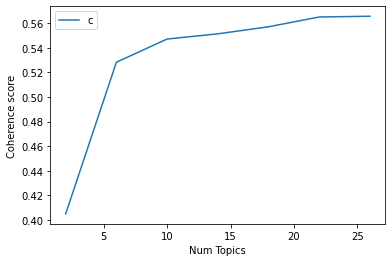

In [ ]:
# Show graph
limit=30; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f6c764235d0>  has Coherence Value of 0.4049
Num Topics = <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f6c770afe90>  has Coherence Value of 0.5283
Num Topics = <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f6c7a08fb10>  has Coherence Value of 0.5472
Num Topics = <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f6c77098290>  has Coherence Value of 0.5514
Num Topics = <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f6c77098ad0>  has Coherence Value of 0.5571
Num Topics = <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f6c7a10b810>  has Coherence Value of 0.5651
Num Topics = <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f6c766c2b10>  has Coherence Value of 0.5657


In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_state=100)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.134*"product" + 0.086*"order" + 0.034*"purchase" + 0.024*"item" + '
  '0.024*"receive" + 0.021*"arrive" + 0.021*"review" + 0.021*"package" + '
  '0.019*"company" + 0.015*"ship"'),
 (1,
  '0.100*"buy" + 0.079*"price" + 0.072*"find" + 0.067*"store" + 0.053*"money" '
  '+ 0.027*"local" + 0.025*"pack" + 0.022*"grocery" + 0.021*"cheap" + '
  '0.017*"sell"'),
 (2,
  '0.154*"love" + 0.132*"great" + 0.045*"year" + 0.041*"recommend" + '
  '0.034*"find" + 0.024*"highly" + 0.022*"buy" + 0.020*"friend" + '
  '0.019*"family" + 0.018*"perfect"'),
 (3,
  '0.061*"chocolate" + 0.048*"eat" + 0.037*"bar" + 0.036*"snack" + '
  '0.034*"cookie" + 0.030*"milk" + 0.025*"taste" + 0.024*"cereal" + '
  '0.023*"candy" + 0.023*"sweet"'),
 (4,
  '0.044*"day" + 0.032*"work" + 0.031*"feel" + 0.028*"bad" + 0.025*"smell" + '
  '0.019*"give" + 0.017*"time" + 0.017*"start" + 0.014*"oil" + 0.013*"week"'),
 (5,
  '0.049*"bag" + 0.036*"box" + 0.024*"open" + 0.021*"package" + 0.014*"put" + '
  '0.013*"container" + 